In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot  as plt

from sklearn.preprocessing import OneHotEncoder

sns.set_theme(style = "whitegrid")

In [2]:
INDEX_TO_SEASON = {
    1: 'Primavera',
    2: 'Verão',
    3: 'Outono',
    4: 'Inverno'
}
INDEX_TO_WEATHER = {
    1: "Limpo/Parcialmente Nublado",
    2: "Neblina",
    3: "Neve/Chuvoso",
    4: "Chuva Forte/Neve + Névoa",
}

In [3]:
bikes = pd.read_csv("data/train.csv")
bikes = bikes.astype({"datetime":"datetime64[ns]"}).set_index("datetime")
bikes = bikes.drop(columns=["casual", "registered"])

bikes["season"] = bikes["season"].apply(lambda x: INDEX_TO_SEASON[x])
bikes["holiday"] = bikes["holiday"].apply(lambda x: "Sim" if x == 1 else "Não")
bikes["workingday"] = bikes["workingday"].apply(lambda x: "Sim" if x == 1 else "Não")
bikes["weather"] = bikes["weather"].apply(lambda x: INDEX_TO_WEATHER[x])

In [4]:
# quebrando por mês para fazer o foward fill, sem isso o asfreq insere muitos NaNs (os últimos dias de cada mês)
bikes_monthly = {(month.year, month.month):group.asfreq("H") for month, group in bikes.groupby(pd.Grouper(freq='1M'))}

groups = []
for month, group in bikes_monthly.items():
    nans = group.isna().any(axis=1).sum()
    if nans > 0:
        print(f"{month}: {nans} NaNs")
    groups.append(group.ffill())

bikes = pd.concat(groups)

(2011, 1): 25 NaNs
(2011, 2): 10 NaNs
(2011, 3): 10 NaNs
(2011, 4): 1 NaNs
(2011, 9): 3 NaNs
(2011, 10): 1 NaNs
(2012, 1): 3 NaNs
(2012, 2): 1 NaNs
(2012, 3): 1 NaNs
(2012, 4): 2 NaNs
(2012, 11): 1 NaNs


In [5]:
bikes = bikes.astype({
    "count" : int,
    "humidity" : int,
})

In [6]:
categorical_columns = ["season", "weather", "holiday", "workingday"]

for col in categorical_columns:
    ohe = OneHotEncoder(sparse=False,)
    new_cols = ohe.fit_transform(bikes[[col]])
    ohe.categories_
    bikes[[f"{col}={c}" for c in ohe.categories_[0]]] = new_cols

In [7]:
bikes = bikes.drop(columns = categorical_columns)

In [8]:
bikes

,temp,atemp,humidity,windspeed,count,season=Inverno,season=Outono,season=Primavera,season=Verão,weather=Chuva Forte/Neve + Névoa,weather=Limpo/Parcialmente Nublado,weather=Neblina,weather=Neve/Chuvoso,holiday=Não,holiday=Sim,workingday=Não,workingday=Sim
datetime,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,9.84,14.395,81,0.0000,16,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2011-01-01 01:00:00,9.02,13.635,80,0.0000,40,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2011-01-01 02:00:00,9.02,13.635,80,0.0000,32,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2011-01-01 03:00:00,9.84,14.395,75,0.0000,13,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2011-01-01 04:00:00,9.84,14.395,75,0.0000,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,15.58,19.695,50,26.0027,336,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2012-12-19 20:00:00,14.76,17.425,57,15.0013,241,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2012-12-19 21:00:00,13.94,15.910,61,15.0013,168,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [9]:
# Box plot para análise de outliers (em variáveis não categóricas)

non_categorical = ["temp","atemp","humidity","windspeed"]

# Normalização de valores (min max)
normalized_bikes = (bikes - bikes.min()) / (bikes.max() - bikes.min())

def plot_boxplot(bikes: pd.DataFrame, save=True, plot=False):
    fig, ax = plt.subplots(figsize=(18, 8))
    
    ax.set_title('Boxplot dos dados não categóricos normalizados', weight='bold', fontsize=25)
    data = pd.melt(bikes)
    data.rename(columns={"variable": "atributos", "value": "valores"}, inplace=True)
    sns.boxplot(x="atributos", y="valores",data=data)

    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    
    if save:
        fig.savefig(f"preproc/pre_outlier_boxplot.png")
    
    if not plot:
        plt.close()

    return fig

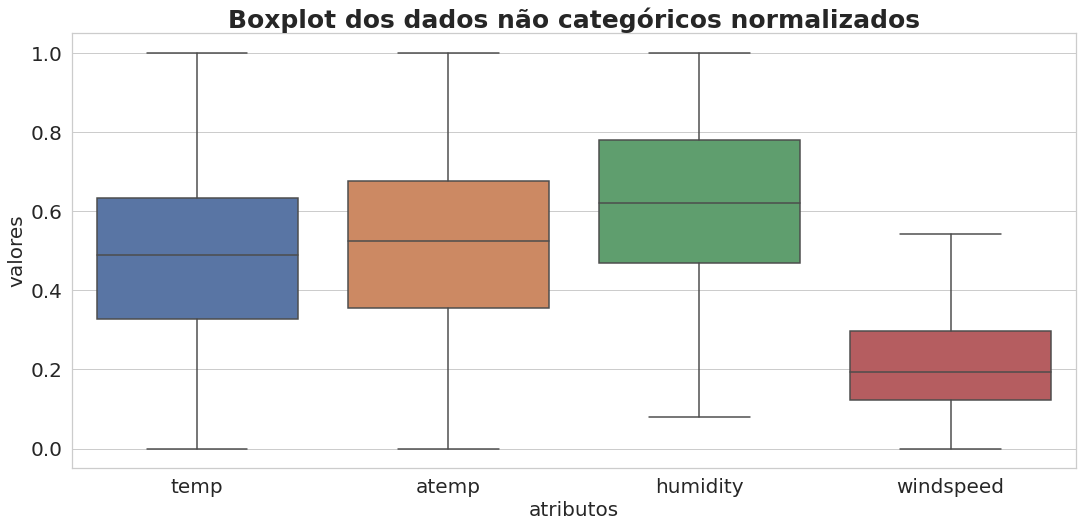

In [28]:
plot_boxplot(normalized_bikes[non_categorical])

In [11]:
categorical_features = [
    "season=Inverno",
    "season=Outono",
    "season=Primavera",
    "season=Verão",
    "weather=Chuva Forte/Neve + Névoa",
    "weather=Limpo/Parcialmente Nublado",
    "weather=Neblina",
    "weather=Neve/Chuvoso",
    "holiday=Não",
    "holiday=Sim",
    "workingday=Não",
    "workingday=Sim",
]
numerical_features = [
    "temp",
    "atemp",
    "humidity",
    "windspeed",
]

In [12]:
bikes

,temp,atemp,humidity,windspeed,count,season=Inverno,season=Outono,season=Primavera,season=Verão,weather=Chuva Forte/Neve + Névoa,weather=Limpo/Parcialmente Nublado,weather=Neblina,weather=Neve/Chuvoso,holiday=Não,holiday=Sim,workingday=Não,workingday=Sim
datetime,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,9.84,14.395,81,0.0000,16,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2011-01-01 01:00:00,9.02,13.635,80,0.0000,40,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2011-01-01 02:00:00,9.02,13.635,80,0.0000,32,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2011-01-01 03:00:00,9.84,14.395,75,0.0000,13,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2011-01-01 04:00:00,9.84,14.395,75,0.0000,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,15.58,19.695,50,26.0027,336,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2012-12-19 20:00:00,14.76,17.425,57,15.0013,241,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2012-12-19 21:00:00,13.94,15.910,61,15.0013,168,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [21]:
normalized_bikes = normalized_bikes[normalized_bikes['humidity'] > 0]

In [27]:
normalized_bikes = normalized_bikes[normalized_bikes['windspeed'] < 0.57]

In [22]:
normalized_bikes

,temp,atemp,humidity,windspeed,count,season=Inverno,season=Outono,season=Primavera,season=Verão,weather=Chuva Forte/Neve + Névoa,weather=Limpo/Parcialmente Nublado,weather=Neblina,weather=Neve/Chuvoso,holiday=Não,holiday=Sim,workingday=Não,workingday=Sim
datetime,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,0.224490,0.305068,0.81,0.000000,0.015369,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2011-01-01 01:00:00,0.204082,0.288064,0.80,0.000000,0.039959,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2011-01-01 02:00:00,0.204082,0.288064,0.80,0.000000,0.031762,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2011-01-01 03:00:00,0.224490,0.305068,0.75,0.000000,0.012295,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2011-01-01 04:00:00,0.224490,0.305068,0.75,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,0.367347,0.423649,0.50,0.456213,0.343238,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2012-12-19 20:00:00,0.346939,0.372860,0.57,0.263195,0.245902,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2012-12-19 21:00:00,0.326531,0.338964,0.61,0.263195,0.171107,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [29]:
cols = ['temp','atemp','humidity','windspeed','season=Inverno','season=Primavera','weather=Neblina','weather=Neve/Chuvoso','count']
normalized_bikes[cols].to_csv("data.csv")